In [1]:
import pandas as pd
import numpy as np
import math
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.style.use("default")

G = 6.674e-8

In [2]:
def g(E, e, M):
    """
    Return error on solution to Kepler's equation
    """
    return E - e*np.sin(E) - M


def E_sol(e, M, error=2e-16, max_iter=1e3):
    """
    Solve for E using Newton's method
    """
    # initial guess
    E = M + 0.85*e*np.sign(np.sin(M))

    i = 0
    # iterate until the specified precision is reached up to limited # of iterations
    while (abs(g(E, e, M)).any() > error) & (i < max_iter):
        E -= g(E, e, M)/(1 - e*np.cos(E))
        i += 1

    return E

max error:	 0.0
max error:	 4.440892098500626e-16
max error:	 8.881784197001252e-16
max error:	 8.881784197001252e-16
max error:	 8.881784197001252e-16


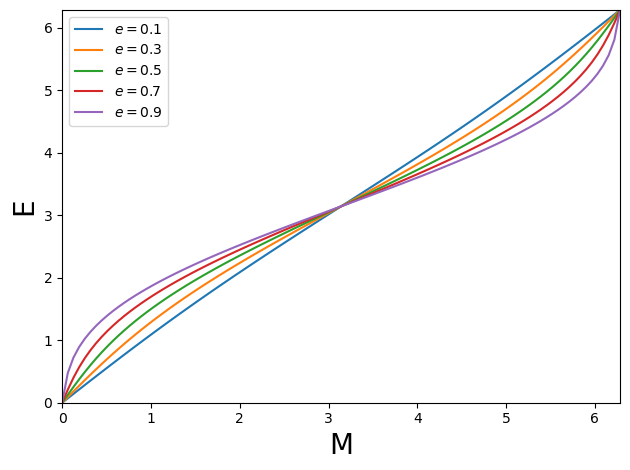

In [3]:
M = np.linspace(0, 2*math.pi, 100)

for e in np.arange(0.1, 1, .2):
    E = E_sol(e, M)
    plt.plot(M, E, label=r'$e={}$'.format(round(e,1)))
    print('max error:\t', max(g(E, e, M)))
plt.legend(loc='upper left')
plt.xlim(M.min(), M.max())
plt.ylim(M.min(), M.max())
plt.xlabel('M', fontsize=20)
plt.ylabel('E', fontsize=20)
plt.tight_layout()
plt.show()

In [4]:
def rv(t, K, P, tp, e, pomega, gamma):
    """
    Radial velocity model of the star

    K: rv amplitude (km/s)
    P: peroid (days)
    tp: time of periastron (days)
    e: eccentricity
    pomega: pericenter angle (rad)
    gamma: velocity of center of mass
    """
    # K = (2*math.pi*G)/(P*(1-e**2)**(3/2))**(1/3) * Mp*np.sin(i)/(Ms + Mp)**(2/3)

    M = 2*math.pi/P * (t - tp)
    E = E_sol(e, M)

    f = 2*np.arctan(((1+e)/(1-e))**0.5 * np.tan(E/2))

    vz = K*np.cos(f)*np.cos(pomega) - K*np.sin(f)*np.sin(pomega) + gamma + K*e*np.cos(pomega)

    return vz

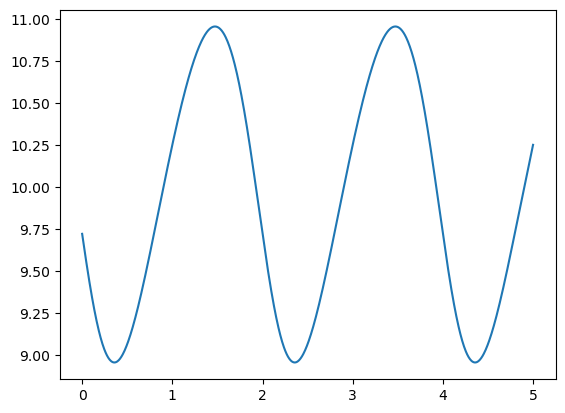

In [5]:
K, P, tp, e, pomega, gamma =  1, 2, 0.05, 0.1, 2, 10
t = np.linspace(0,5,1000)

vz = rv(t, K, P, tp, e, pomega, gamma)
plt.plot(t, vz);

In [6]:
def phase_fold(time, rv_val, rv_err, P, tc=0):
    
    fold = (time-tc) % P
    phase_sort = np.argsort(fold)

    phase_time = fold[phase_sort]
    phase_rv_val = rv_val[phase_sort]
    phase_rv_err = rv_err[phase_sort]
    
    return phase_time, phase_rv_val, phase_rv_err

In [7]:
import pandas as pd

df = pd.read_csv("../data/rv/TOI1696_rv_all.dat")
df

,bjd,rv,rv_err
0,2.459245e+06,-0.081987,0.00817
1,2.459488e+06,0.046578,0.00702
2,2.459508e+06,0.057321,0.00929
3,2.459508e+06,0.025829,0.00704
4,2.459510e+06,0.063226,0.00891
5,2.459510e+06,0.000000,0.00732
6,2.459515e+06,-0.014359,0.00818
7,2.459515e+06,-0.029625,0.00720
8,2.459531e+06,-0.079214,0.00825


In [13]:
# https://exofop.ipac.caltech.edu/tess/target.php?id=470381900
Porb = 2.50071474655903, 0.000511482
tc = 2458816.697706, 0.0027523146

<ErrorbarContainer object of 3 artists>

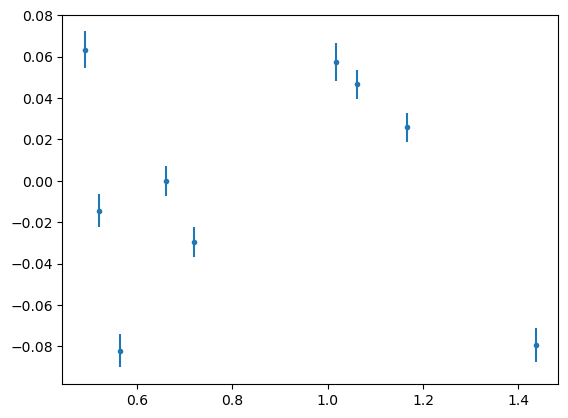

In [14]:
phase_time, phase_rv_val, phase_rv_err = phase_fold(df.bjd.values, 
                                                    df.rv.values, 
                                                    df.rv_err.values, 
                                                    P=Porb[0],
                                                    tc=tc[0]
                                                   ) 
plt.errorbar(phase_time, phase_rv_val, yerr=phase_rv_err, fmt='.')

In [16]:
import astropy.units as u
import astropy.constants as c
from uncertainties import unumpy

Ms_samples = np.random.normal(0.2537,0.0064, size=1000)
mp_samples = np.ones_like(Ms_samples)
Porb_samples = np.random.normal(Porb[0], Porb[1], size=len(Ms_samples))
inc_samples = np.random.uniform(low=88, high=90, size=len(Ms_samples))

Ms = (0.2537, 0.0064)
mp = (10,1)

In [18]:
def get_Mp_from_K(Porb_samples, Ms_samples, K_samples, e=0, inc=inc_samples):
    """
    """
    P = Porb_samples*u.day.to(u.second)*u.second
    Ms = Ms_samples*u.Msun.to(u.kg)*u.kg
    K = K_samples*(u.m/u.second)
    Mp_samples = ((P*Ms**2)/(2*np.pi*c.G))**(1/3)*(K*(1-e**2)**0.5)/np.sin(inc)
    return Mp_samples

Text(0.5, 1.0, 'TOI 1696')

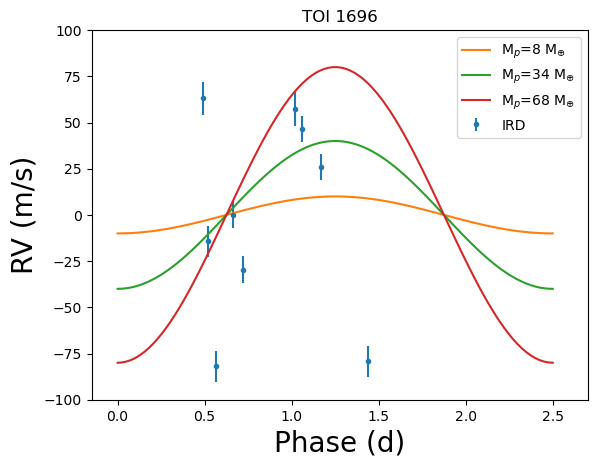

In [33]:
plt.errorbar(phase_time, phase_rv_val*1000, yerr=phase_rv_err*1000, fmt='.', label='IRD')

P = np.median(Porb_samples)
Ms = np.median(Ms_samples)

phase_model = np.linspace(0, P, 100)
for K in [10,40,80]:
    Mp = get_Mp_from_K(P, Ms, K_samples=K, e=0, inc=np.pi/2).to(u.Mearth).value
    vz = rv(phase_model, K, P, tp=0, e=0, pomega=np.pi, gamma=0)
    plt.plot(phase_model, vz, label=r'M$_p$='+f'{int(Mp)} '+r'M$_{\oplus}$');
plt.legend(loc=0)
plt.xlabel('Phase (d)', fontsize=20)
plt.ylabel('RV (m/s)', fontsize=20)
plt.ylim(-100,100)
plt.xlim(tp-0.2, P+0.2)
plt.title("TOI 1696")